In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv("bike_marketing.csv")

In [2]:
data.head(3)

,company_num,google_adwords,facebook,twitter,marketing_total,revenues,employees,pop_density
0,1,65.66,47.86,52.46,166,39.26,5,High
1,2,39.10,55.20,77.40,172,38.90,7,Medium
2,3,174.81,52.01,68.01,295,49.51,11,Medium


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company_num      172 non-null    int64  
 1   google_adwords   172 non-null    float64
 2   facebook         172 non-null    float64
 3   twitter          172 non-null    float64
 4   marketing_total  172 non-null    int64  
 5   revenues         172 non-null    float64
 6   employees        172 non-null    int64  
 7   pop_density      172 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 10.9+ KB


- 1. pop_density(category변환, pop_density별 revenues 평균차이가 있는지 통계분석 시행)

In [4]:
data['pop_density']=data['pop_density'].astype('category')

In [5]:
low=data.loc[data['pop_density']=='Low', 'revenues']
medium=data.loc[data['pop_density']=='Medium', 'revenues']
high=data.loc[data['pop_density']=='High', 'revenues']

H0 : pop_density 별 매출에 차이가 없다.
    
H1 : pop_density 집단 간 매출이 모두 같다고 할수는 없다.

In [6]:
import scipy.stats as stats
stats.shapiro(low)

ShapiroResult(statistic=0.9840328693389893, pvalue=0.5353288650512695)

In [7]:
stats.shapiro(medium)

ShapiroResult(statistic=0.9450081586837769, pvalue=0.017985567450523376)

In [8]:
stats.shapiro(high)

ShapiroResult(statistic=0.9552056789398193, pvalue=0.04857487604022026)

In [9]:
stats.kruskal(low, medium, high)

KruskalResult(statistic=0.900557928910252, pvalue=0.6374503008400596)

귀무가설을 기각할 수 없다. 즉 pop_density 별 매출에 차이가 없다.

- 2. 회귀분석(전진선택법)

In [27]:
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

model = ols('revenues ~ google_adwords + facebook +  twitter + marketing_total + employees' , data=data ).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               revenues   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     228.9
Date:                Wed, 21 Sep 2022   Prob (F-statistic):           1.57e-72
Time:                        20:09:49   Log-Likelihood:                -369.26
No. Observations:                 172   AIC:                             750.5
Df Residuals:                     166   BIC:                             769.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          28.4433      0.596     47.706      0.000      27.266      29.621
google_adwords      1.2110      0.571      2.122      0.035       0.084       2.338
facebook            1.3464      0.571      2.356      0.020       0.218       2.474
twitter             1.1724      0.571      2.052      0.042       0.045       2.300
marketing_total    -1.1696      0.571     -2.049      0.042      -2.297      -0.043
employees           0.3865      0.104      3.708      0.000       0.181       0.592
==============================================================================
Omnibus:                        3.945   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.974
Skew:                          -0.341   Prob(JB):                        0.137
Kurtosis:                       2.702   Cond. No.                     2.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

모든 변수를 포함시킨 모델에서 p-value가 유의하므로 모든 변수는 유의함을 확인할 수 있음

- 3. 잔차분석 수행

- 더빈왓슨(잔차의 독립성)

In [28]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model.resid)

2.111378372860919

더빈왓슨 검정 결과값이 2에 가깝기 때문에 독립성 만족

더빈왓슨 검정은 0이면 잔차들이 양의 자기상관을 갖고, 2이면 자기상관이 없는 독립성을 갖고, 4이면 잔차들이 음의 자기상관을 갖는다고 해석한다. 이 모형은 2.11이므로 잔차의 독립성을 만족한다고 볼 수 있다.

- 샤피로(잔차의 정규성)

In [30]:
import scipy.stats
scipy.stats.shapiro(model.resid)

ShapiroResult(statistic=0.9865776300430298, pvalue=0.09909190982580185)

p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다. 즉 정규성을 따른다

- 잔차의 등분산성

C:\Users\taeeu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


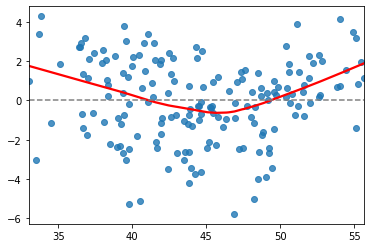

In [36]:
fitted = model.predict(data)
residual = data['revenues'] - fitted

import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(fitted, residual, lowess=True, line_kws = {'color':'red'})
plt.plot([fitted.min(), fitted.max()], [0,0], '--', color='grey')

C:\Users\taeeu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

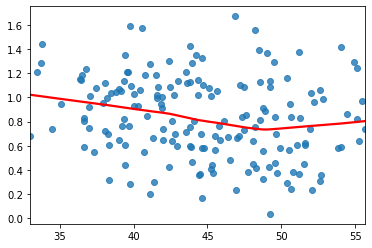

In [37]:
sr=scipy.stats.zscore(residual)
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color':'red'})

빨간색 실선이 수평선을 그리는 것이 등분산성을 만족한다는 것인데 그렇지 못함.회귀직선이 y값을 잘 적합하지 못함을 의미함. 또한 해당 점들은 이상치일 가능성이 있다.

- 극단값

In [39]:
from statsmodels.stats.outliers_influence import OLSInfluence
cd, _=OLSInfluence(model).cooks_distance
cd.sort_values(ascending=False).head()

110    0.061089
152    0.049946
106    0.046469
108    0.045954
114    0.044333
dtype: float64

특히 110, 152, 106번 자료가 예측에서 많이 벗어남을 확인